# Niger Conflict Analysis from ACLED Data

#### Overview of ACLED Data:
The Armed Conflict Location and Event Data (ACLED) is a disaggregated data, which reports information on conflict events in every country and territory in the world. It encompasses data on the type, agents, date, location and other attributes of demonstration events, political violence events, strategic developments, and other non-violence politically-relevant developments at specific points in time. The data is collected in real-time and published on a weekly basis.


#### Background of work:
Following the coup in Niamey on 07/26/2023, we would like to understand the trend of reported conflict events over time in Niger. For this analysis, ACLED data is downloaded for a 5-year period (2019-present), however the primary focus is on 2022-2023.

In [1]:
## Load libraries and data
import pandas as pd
import numpy as np
import folium
from datetime import datetime
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
from scipy.stats import gmean
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import bokeh
from bokeh.io import show, output_file, output_notebook
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Slider, CustomJS, Legend, TabPanel, Span, Column, Tabs, GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import linear_palette
from bokeh.layouts import column, row
from bokeh.transform import transform
import plotly.express as px
from folium.plugins import HeatMapWithTime
import seaborn as sns
import matplotlib.pyplot as plt
import holoviews as hv
import panel as pn
import hvplot.pandas
from holoviews import save as hv_save
from bioinfokit import analys
from holoviews import dim, opts
from holoviews.streams import Stream, param
import plotly.graph_objects as go
from IPython.display import display, clear_output
import ipywidgets as widgets
from plotly.subplots import make_subplots
from bokeh.transform import factor_cmap
from PIL import Image






from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)





## Data
niger_adm1 = gpd.read_file(
    "../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm1_IGNN_20230720.shp"
)

niger_adm2 = gpd.read_file(
    "../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm2_IGNN_20230720.shp"
)

niger_adm3 = gpd.read_file(
    "../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm3_IGNN_20230720.shp"
)




niger_df = pd.read_csv("../../data/Niger_conflict_data.csv")



In [2]:
color_palette = [
    "#4E79A7",  # Blue
    "#F28E2B",  # Orange
    "#E15759",  # Red
    "#76B7B2",  # Teal
    "#59A14F",  # Green
    "#EDC948",  # Yellow
    "#B07AA1",  # Purple
    "#FF9DA7",  # Pink
    "#9C755F",  # Brown
    "#BAB0AC",  # Gray
    "#7C7C7C",  # Dark gray
    "#6B4C9A",  # Violet
    "#D55E00",  # Orange-red
    "#CC61B0",  # Magenta
    "#0072B2",  # Bright blue
    "#329262",  # Peacock green
    "#9E5B5A",  # Brick red
    "#636363",  # Medium gray
    "#CD9C00",  # Gold
    "#5D69B1",  # Medium blue
]

In [3]:


def get_line_plot(
    ooklaUsers,
    title,
    source,
    subtitle=None,
    measure="conflictIndex",
    category="ADM2_FR",
):
    p2 = figure(
        x_axis_type="datetime", width=1000, height=400, toolbar_location="above"
    )
    p2.add_layout(Legend(), "right")

    for id, adm2 in enumerate(ooklaUsers[category].unique()):
        df = ooklaUsers[ooklaUsers[category] == adm2][
            ["event_date_map", measure]
        ].reset_index(drop=True)
        p2.line(
            df["event_date_map"],
            df[measure],
            line_width=2,
            line_color=color_palette[id % len(color_palette)],  ## index doesn't exceed the palette size
            legend_label=adm2,
        )

    p2.legend.click_policy = "hide"
    if subtitle is not None:
        p2.title = subtitle

    title_fig = figure(
        title=title,
        toolbar_location=None,
        width=800,
        height=40,
    )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "20pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width = 0

    sub_title = figure(
        title=source,
        toolbar_location=None,
        width=800,
        height=40,
    )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style = "normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width = 0

    layout = column(title_fig, p2, sub_title)


    return layout

### 1). Average monthly conflict and fatalities over the years

The recorded data from January 1, 2019, to May 15, 2024, clearly shows that aside from the peak in average monthly conflicts in 2022, the average monthly conflict occurrences and consequent fatalities in Niger worsened after the coup in 2023. In 2024, the average fatalities per month have already tied with 2021 for the highest at 125, and the average conflicts per month are the second-highest at 71 within just five months.

To fully reveal the extent of the spike in conflicts and fatalities post-coup, between the years 2022 to 2024, we observe a 3-month moving average where we clearly see that fatalities increased more rapidly than conflict occurence. 

In [4]:
# ## Group by year 
# summ_years = niger_df.groupby('year').agg({
#     'event_id_cnty': 'count',
#     'fatalities': 'sum',
#     'location': pd.Series.nunique,  
#     'month': pd.Series.nunique        
# }).rename(columns={
#     'event_id_cnty': 'total_conflicts',
#     'fatalities': 'total_fatalities',
#     'location': 'num_locations',
#     'month': 'num_months'
# }).reset_index()

# ## Monthly averages for conflicts and fatalities
# summ_years['avg_monthly_conflicts'] = (summ_years['total_conflicts'] / summ_years['num_months']).round(1)
# summ_years['avg_monthly_fatalities'] = (summ_years['total_fatalities'] / summ_years['num_months']).round(1)


# ## Plotting average monthly conflict and fatalities over the years
# plt.figure(figsize=(10, 6))
# plt.plot(summ_years["year"], summ_years["avg_monthly_conflicts"], marker='o', label='Average Monthly Conflicts', color='darkorange')
# plt.plot(summ_years["year"], summ_years["avg_monthly_fatalities"], marker='s', label='Average Monthly Fatalities', color='darkred')
# plt.title('Comparison of Average Monthly Conflicts and Fatalities Over the Years (2019 - 2024)')
# plt.xlabel('Year')
# plt.ylabel('Average Monthly Values')
# plt.legend()
# plt.grid(False)
# plt.show()




# niger_df['event_date'] = pd.to_datetime(niger_df['event_date'], format='%d-%m-%Y')
# niger_df['month_year'] = niger_df['event_date'].dt.to_period('M')

# ## Filter data for 2023 and 2024
# trend_2023 = niger_df[niger_df['year'].isin([2023, 2024])]

# ## Group by month_year and aggregate the counts and sums
# trend_2023 = trend_2023.groupby(['month_year']).agg({
#     'event_id_cnty': 'count',
#     'fatalities': 'sum'
# }).rename(columns={
#     'event_id_cnty': 'total_conflicts',
#     'fatalities': 'total_fatalities'
# }).reset_index()

# ## Calculate the 3-month moving average
# trend_2023['conflicts_3mo_avg'] = trend_2023['total_conflicts'].rolling(window=3).mean()
# trend_2023['fatalities_3mo_avg'] = trend_2023['total_fatalities'].rolling(window=3).mean()

# ## Plot the 3-month moving average
# plt.figure(figsize=(12, 8))
# plt.plot(trend_2023['month_year'].dt.to_timestamp(), trend_2023['conflicts_3mo_avg'], marker='o', label='3-Month Avg Conflicts', color='darkorange')
# plt.plot(trend_2023['month_year'].dt.to_timestamp(), trend_2023['fatalities_3mo_avg'], marker='o', label='3-Month Avg Fatalities', color='darkred')

# ## Highlight the period between 2023-11 and 2024-01
# start_highlight = pd.Timestamp('2023-11-01')
# end_highlight = pd.Timestamp('2024-01-31')
# plt.axvline(x=start_highlight, color='grey', linestyle='--')
# plt.axvline(x=end_highlight, color='grey', linestyle='--')

# ## Annotate the highlighted period
# plt.fill_betweenx(
#     plt.ylim(), start_highlight, end_highlight, color='grey', alpha=0.2, label='Timeframe with a steady uptrend in fatalities'
# )

# plt.title('3-Month Moving Average of Conflicts and Fatalities (2023-2024)')
# plt.xlabel('Month')
# plt.ylabel('3-Month Average Values')
# plt.legend()
# plt.grid(False)
# plt.show()


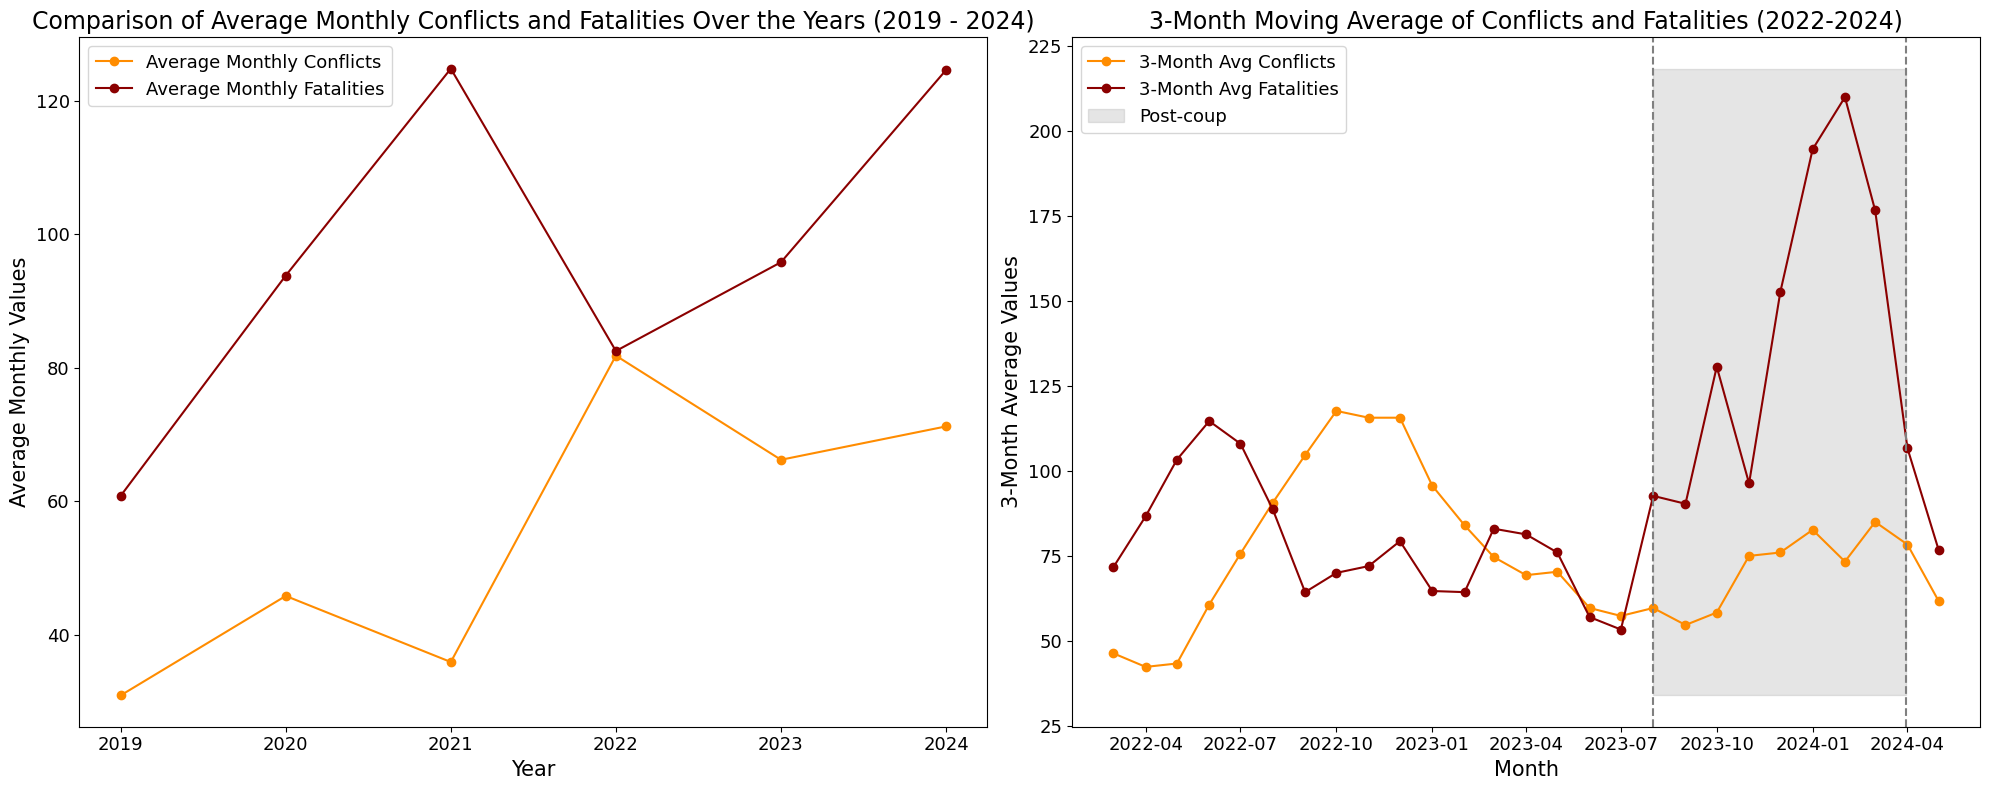

In [5]:

niger_df['event_date'] = pd.to_datetime(niger_df['event_date'], format='%d-%m-%Y')
niger_df['month_year'] = niger_df['event_date'].dt.to_period('M')

# Group by year and calculate the yearly summary statistics
summ_years = niger_df.groupby('year').agg({
    'event_id_cnty': 'count',
    'fatalities': 'sum',
    'location': pd.Series.nunique,
    'month': pd.Series.nunique
}).rename(columns={
    'event_id_cnty': 'total_conflicts',
    'fatalities': 'total_fatalities',
    'location': 'num_locations',
    'month': 'num_months'
}).reset_index()

# Calculate monthly averages for conflicts and fatalities
summ_years['avg_monthly_conflicts'] = (summ_years['total_conflicts'] / summ_years['num_months']).round(1)
summ_years['avg_monthly_fatalities'] = (summ_years['total_fatalities'] / summ_years['num_months']).round(1)

# Filter data for 2022, 2023 and 2024
trend_2023 = niger_df[niger_df['year'].isin([2022, 2023, 2024])]

# Group by month_year and aggregate the counts and sums
trend_2023 = trend_2023.groupby(['month_year']).agg({
    'event_id_cnty': 'count',
    'fatalities': 'sum'
}).rename(columns={
    'event_id_cnty': 'total_conflicts',
    'fatalities': 'total_fatalities'
}).reset_index()

# Calculate the 3-month moving average
trend_2023['conflicts_3mo_avg'] = trend_2023['total_conflicts'].rolling(window=3).mean()
trend_2023['fatalities_3mo_avg'] = trend_2023['total_fatalities'].rolling(window=3).mean()

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot average monthly conflicts and fatalities over the years
ax[0].plot(summ_years["year"], summ_years["avg_monthly_conflicts"], marker='o', label='Average Monthly Conflicts', color='darkorange')
ax[0].plot(summ_years["year"], summ_years["avg_monthly_fatalities"], marker='o', label='Average Monthly Fatalities', color='darkred')
ax[0].set_title('Comparison of Average Monthly Conflicts and Fatalities Over the Years (2019 - 2024)', fontsize = 17)
ax[0].set_xlabel('Year', fontsize = 15)
ax[0].set_ylabel('Average Monthly Values', fontsize = 15)
ax[0].legend(fontsize = 13)
ax[0].grid(False)
ax[0].tick_params(axis='both', which='major', labelsize=13)



# Plot the 3-month moving average
ax[1].plot(trend_2023['month_year'].dt.to_timestamp(), trend_2023['conflicts_3mo_avg'], marker='o', label='3-Month Avg Conflicts', color='darkorange')
ax[1].plot(trend_2023['month_year'].dt.to_timestamp(), trend_2023['fatalities_3mo_avg'], marker='o', label='3-Month Avg Fatalities', color='darkred')

# Highlight the period between 2023-11 and 2024-01
start_highlight = pd.Timestamp('2023-08-01')
end_highlight = pd.Timestamp('2024-03-31')
ax[1].axvline(x=start_highlight, color='grey', linestyle='--')
ax[1].axvline(x=end_highlight, color='grey', linestyle='--')

# Annotate the highlighted period
ax[1].fill_betweenx(
    ax[1].get_ylim(), start_highlight, end_highlight, color='grey', alpha=0.2, label='Post-coup'
)

ax[1].set_title('3-Month Moving Average of Conflicts and Fatalities (2022-2024)', fontsize = 17)
ax[1].set_xlabel('Month', fontsize = 15)
ax[1].set_ylabel('3-Month Average Values', fontsize = 15)
ax[1].legend(fontsize = 13)
ax[1].grid(False)
ax[1].tick_params(axis='both', which='major', labelsize=13)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


### 2). Conflict Occurence by top 5 Event types (2022 - 2024)

Before the coup, "strategic development" conflict events and "violence against civilians" consistently dominated other event types such as "battles," "explosions/remote violence," and "protests." Notably, after the coup, specifically in November, there was a clear spike (an all-time high for the years under consideration), in the total number of conflicts attributed to "strategic developments."

This spike was likely triggered by the French president's announcement on September 24, 2023, regarding the withdrawal of troops and diplomatic staff, including Ambassador Sylvain Itte. He highlighted that the full withdrawal of the 1,500 French troops stationed in the country was expected by the end of the year.

Immediately following this spike in strategic development conflict events, there was another all-time high in the number of fatalities caused by "explosions/remote violence." In the following month, fatalities caused by "battles" surpassed those from other events. It is important to note that "battles" have generally been the leading cause of fatalities over the years, except during the period around the coup, when "violence against civilians" was responsible for the highest fatalities and conflicts.

##### (a). All Conflicts

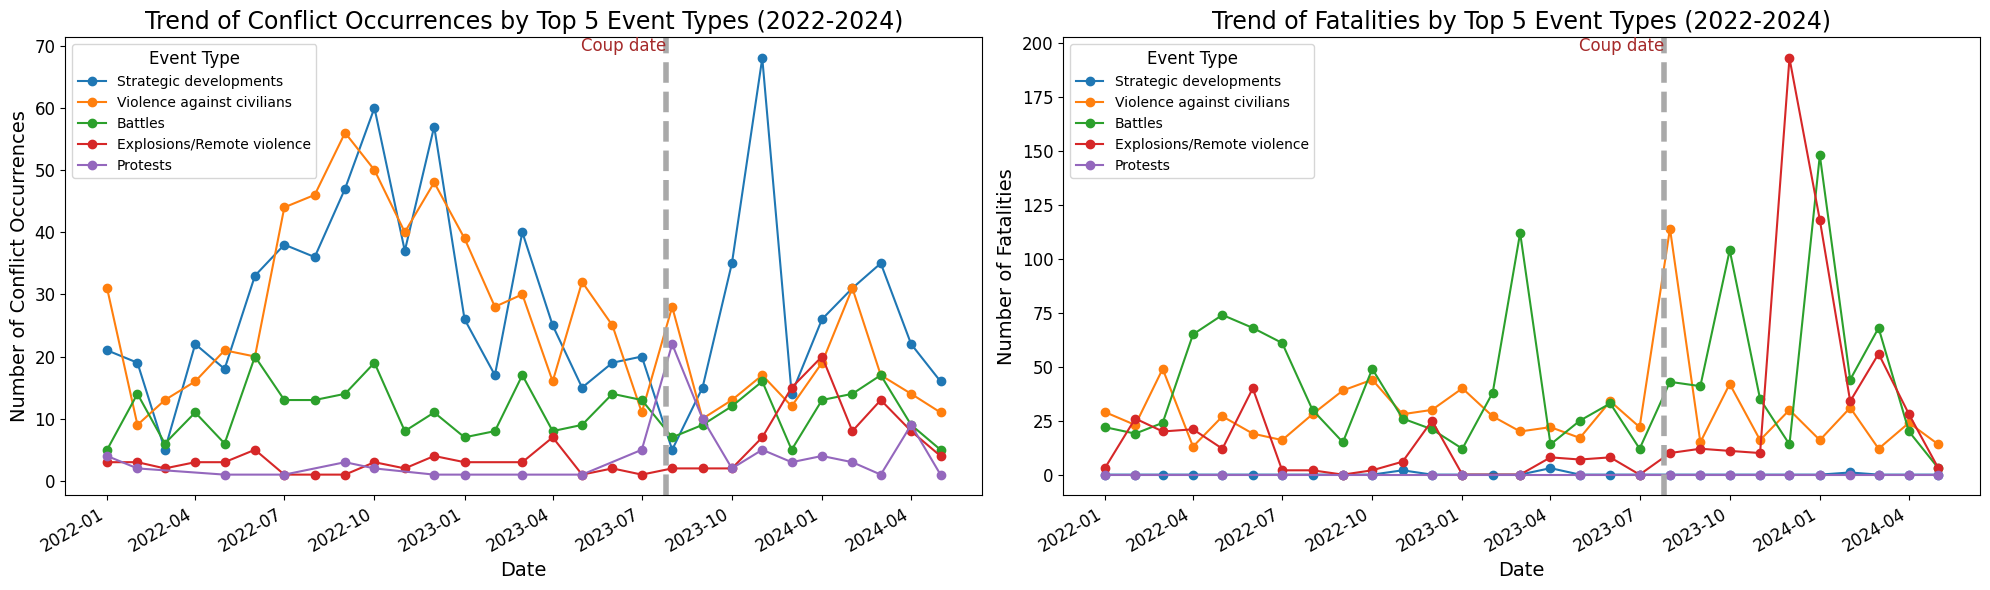

In [6]:

## All Conflicts
niger_df['event_date'] = pd.to_datetime(niger_df['event_date'], format='%d-%m-%Y')
niger_df['month_year'] = niger_df['event_date'].dt.to_period('M')

# Filter data for the years 2022, 2023, and 2024 and for only civilian-targetted
filtered_df1 = niger_df[(niger_df['year'].isin([2022, 2023, 2024]))]


# Group by event_type and month_year, then count occurrences and sum fatalities
grouped = filtered_df1.groupby(['event_type', 'month_year']).agg({
    'event_id_cnty': 'count',
    'fatalities': 'sum'
}).reset_index()

# Find the top 5 event types by total occurrences over the period
top_event_types = grouped.groupby('event_type')['event_id_cnty'].sum().nlargest(5).index

# Filter the grouped DataFrame to include only these top event types
top_events_grouped = grouped[grouped['event_type'].isin(top_event_types)]


# Define color palette
color_palette1 = {
    'Strategic developments': '#1f77b4',  # blue
    'Violence against civilians': '#ff7f0e',  # orange
    'Battles': '#2ca02c',  # green
    'Explosions/Remote violence': '#d62728',  # red
    'Protests': '#9467bd'   # purple
}

# Filter the top event types data
top_event_types = grouped.groupby('event_type')['event_id_cnty'].sum().nlargest(5).index.tolist()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 

# First plot for conflict occurrences
for event_type in top_event_types:
    event_data = top_events_grouped[top_events_grouped['event_type'] == event_type]
    axs[0].plot(event_data['month_year'].dt.to_timestamp(), event_data['event_id_cnty'], marker='o', label=event_type, color=color_palette1[event_type])

# Second plot for fatalities
for event_type in top_event_types:
    event_data = top_events_grouped[top_events_grouped['event_type'] == event_type]
    axs[1].plot(event_data['month_year'].dt.to_timestamp(), event_data['fatalities'], marker='o', label=event_type, color=color_palette1[event_type])

# Highlight the specific date for the coup in both plots
coup_date = pd.Timestamp('2023-07-26')
for ax in axs:
    ax.axvline(x=coup_date, color='darkgrey', linestyle='--', lw=4)
    ax.text(coup_date, ax.get_ylim()[1], 'Coup date', horizontalalignment='right', verticalalignment='top', color='brown', fontsize = 12)

# Formatting the plots
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks interval every 3 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Set the display format for dates
    ax.set_xlabel('Date', fontsize = 14)
    ax.legend(title='Event Type', title_fontsize = 12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
fig.autofmt_xdate()

axs[0].set_ylabel('Number of Conflict Occurrences', fontsize = 14)
axs[0].set_title('Trend of Conflict Occurrences by Top 5 Event Types (2022-2024)', fontsize = 17)

axs[1].set_ylabel('Number of Fatalities', fontsize = 14)
axs[1].set_title('Trend of Fatalities by Top 5 Event Types (2022-2024)', fontsize = 17)

plt.tight_layout()
plt.show()

##### (b). Civilian-targeted conflicts

For civilian-targeted events, "Violence against civilians" was the dominant event type for both fatalities and conflicts. A spike in fatalities caused by "explosions/remote violence" was observed around February 2024.

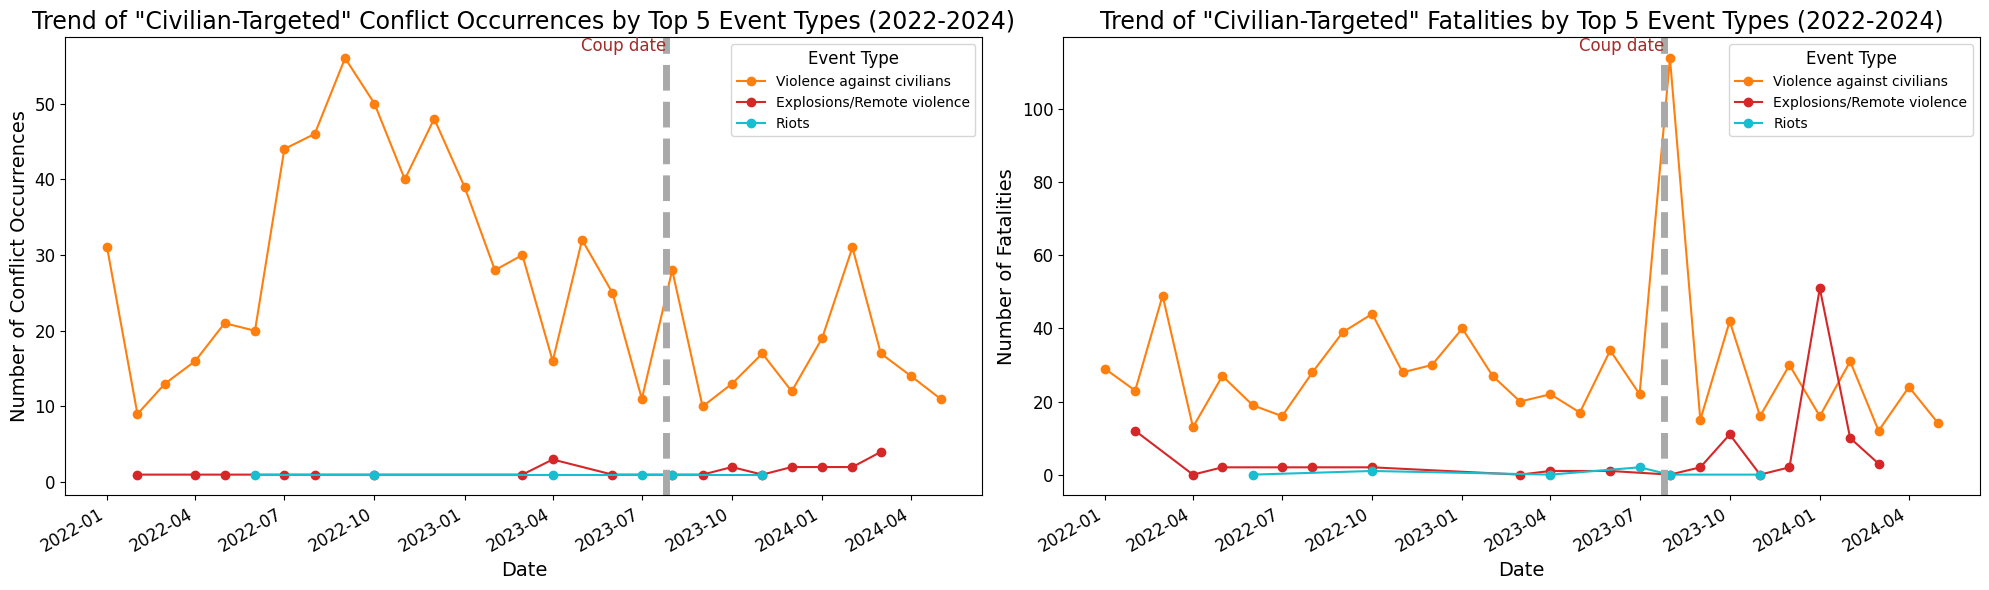

In [7]:
## Civilian Targetted Conflicts
# Filter data for the years 2022, 2023, and 2024 and for only civilian-targetted
filtered_df2 = niger_df[(niger_df['year'].isin([2022, 2023, 2024])) & (niger_df['civilian_targeting'] == "Civilian targeting")]


# Group by event_type and month_year, then count occurrences and sum fatalities
grouped = filtered_df2.groupby(['event_type', 'month_year']).agg({
    'event_id_cnty': 'count',
    'fatalities': 'sum'
}).reset_index()

# Find the top 5 event types by total occurrences over the period
top_event_types = grouped.groupby('event_type')['event_id_cnty'].sum().nlargest(5).index

# Filter the grouped DataFrame to include only these top event types
top_events_grouped = grouped[grouped['event_type'].isin(top_event_types)]



color_palette2 = {
    'Violence against civilians': '#ff7f0e',  # orange
    'Explosions/Remote violence': '#d62728',  # red
    'Riots': '#17becf'   # cyan
}

# Filter the top event types data
top_event_types = grouped.groupby('event_type')['event_id_cnty'].sum().nlargest(5).index.tolist()

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # Create a 1 by 2 subplot grid

# First plot for conflict occurrences
for event_type in top_event_types:
    event_data = top_events_grouped[top_events_grouped['event_type'] == event_type]
    axs[0].plot(event_data['month_year'].dt.to_timestamp(), event_data['event_id_cnty'], marker='o', label=event_type, color=color_palette2[event_type])

# Second plot for fatalities
for event_type in top_event_types:
    event_data = top_events_grouped[top_events_grouped['event_type'] == event_type]
    axs[1].plot(event_data['month_year'].dt.to_timestamp(), event_data['fatalities'], marker='o', label=event_type, color=color_palette2[event_type])

# Highlight the specific date for the coup in both plots
coup_date = pd.Timestamp('2023-07-26')
for ax in axs:
    ax.axvline(x=coup_date, color='darkgrey', linestyle='--', lw=5)
    ax.text(coup_date, ax.get_ylim()[1], 'Coup date', horizontalalignment='right', verticalalignment='top', color='brown', fontsize = 12)

# Formatting the plots
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks interval every 3 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Set the display format for dates
    ax.set_xlabel('Date', fontsize = 14)
    ax.legend(title='Event Type', fontsize = 10, title_fontsize = 12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
fig.autofmt_xdate()

axs[0].set_ylabel('Number of Conflict Occurrences', fontsize = 14)
axs[0].set_title('Trend of "Civilian-Targeted" Conflict Occurrences by Top 5 Event Types (2022-2024)', fontsize = 17)

axs[1].set_ylabel('Number of Fatalities', fontsize = 14)
axs[1].set_title('Trend of "Civilian-Targeted" Fatalities by Top 5 Event Types (2022-2024)', fontsize = 17)

plt.tight_layout()
plt.show()

### 3). Heatmap to show conflict and fatality occurences over past 2 years


Between January 2022 and May 2024, the country experienced the most conflict events in October 2022, with 136 events resulting in 96 fatalities. However, the highest number of fatalities occurred in January 2024, with 283 fatalities from 84 conflicts, followed by December 2023, with 237 fatalities from 49 conflicts. These relatively high fatality numbers were observed ***post-coup***.

In [8]:
##############################################################
### For this cell, make the range of values in the legend for each year to be from the same in terms of least and highest

## Dictionary to map month numbers to month names
month_names = {
    'January': 'Jan', 'February': 'Feb', 'March': 'Mar', 'April': 'Apr',
    'May': 'May', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
    'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'
}

## Filter data for specified years
filtered_df = niger_df[niger_df['year'].isin([2022, 2023, 2024])]

## Aggregate data by year and month
pivot_df1 = (
    filtered_df.groupby(['year', 'month'])
    .size()
    .unstack()
    .rename(columns=month_names)
    [list(month_names.values())]  
)

pivot_df2 = (
    filtered_df.groupby(['year', 'month'])
    ['fatalities'].sum()
    .unstack()
    .rename(columns=month_names)
    [list(month_names.values())]
)

## Color scales for heatmaps
colorscale_conflicts = [
    (0.0, '#F9D423'),  # Dark yellow
    (0.05, '#FF5722'),  # Dark orange
    (1.0, '#C62828')   # Dark red
]

colorscale_fatalities = [
    (0.0, '#C6A300'),  # A darker shade of yellow
    (0.05, '#D84315'),  # A darker shade of orange
    (1.0, '#8E0000')   # A darker shade of red
]


## Create the figures
fig_conflicts = go.Figure()
fig_fatalities = go.Figure()


years = sorted(set(pivot_df1.index).union(pivot_df2.index))

## Populate both figures with their respective traces, all initially invisible
for year in years:
    fig_conflicts.add_trace(
        go.Heatmap(
            z=pivot_df1.loc[year].values.reshape(1, -1),
            x=pivot_df1.columns,
            y=[f"{year} Conflicts"],
            colorscale=colorscale_conflicts,
            xgap = 1,
            ygap = 1,
            visible=False  # Start all traces as invisible
        )
    )
    fig_fatalities.add_trace(
        go.Heatmap(
            z=pivot_df2.loc[year].values.reshape(1, -1),
            x=pivot_df2.columns,
            y=[f"{year} Fatalities"],
            colorscale=colorscale_fatalities,
            xgap = 1,
            ygap = 1,
            visible=False  
        )
    )

## Initialize the slider
slider = widgets.SelectionSlider(
    options=[(str(year), i) for i, year in enumerate(years)],
    value=0,
    description='Year',
    continuous_update=False,
    layout=widgets.Layout(width='20%', margin='auto'),
    style={'description_width': 'initial', 'handle_color': 'lightblue'} 
)


## Update layout and sliders for conflicts figure
fig_conflicts.update_layout(
    title={'text': 'Yearly Data on Conflicts',
          'font': {'size': 19}},
        xaxis=dict(
        tickfont=dict(size=14)),    
        yaxis=dict(
        tickfont=dict(size=14)),
        height = 300,
        margin=dict(t=30)
    )

## Update layout and sliders for fatalities figure
fig_fatalities.update_layout(
    title={'text': 'Yearly Data on Fatalities',
          'font': {'size': 19}},
        xaxis=dict(
        tickfont=dict(size=14)),    
        yaxis=dict(
        tickfont=dict(size=14)),
        height = 300,
        margin=dict(t=30) 
    )



## Function to update the visibility of the traces based on the slider
def update_figures(change):
    year_idx = change['new']  
    
    
    clear_output(wait=True)
    
    # Update visibility based on the selected index
    for fig in [fig_conflicts, fig_fatalities]:
        for i, trace in enumerate(fig.data):
            trace.visible = (i == year_idx)
    
    # Display slider and updated figures
    display(slider)
    display(fig_conflicts)
    display(fig_fatalities)


# Observe slider for changes
slider.observe(update_figures, names='value')

# Display initial state
update_figures({'new': 0})  

SelectionSlider(continuous_update=False, description='Year', layout=Layout(margin='auto', width='20%'), option…

### 4). Calculating Conflict Index

Conflict Index is calculated as a geometric mean of conflict events and fatalities at admin 2 level

In [9]:
acled = niger_df.copy()


def convert_to_gdf(df):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [10]:
def get_acled_by_admin(
    niger_adm2, acled, columns=["ADM2_FR", "ADM2_PCODE", "ADM1_FR"], nearest=False, freq="m"
):
    niger_acled_adm2 = convert_to_gdf(acled)
    if nearest == True:
        niger_acled_adm2 = (
            niger_adm2.sjoin_nearest(niger_acled_adm2)[
                ["event_date", "fatalities", "event_type"] + columns
            ]
            .groupby(
                [pd.Grouper(key="event_date", freq=freq, closed="left")] + columns
            )["fatalities"]
            .agg(["sum", "count"])
            .reset_index()
        )
    else:
        niger_acled_adm2 = (
            niger_adm2.sjoin(niger_acled_adm2)[
                ["event_date", "fatalities", "event_type"] + columns
            ]
            .groupby(
                [pd.Grouper(key="event_date", freq=freq, closed="left")] + columns
            )["fatalities"]
            .agg(["sum", "count"])
            .reset_index()
        )

        ### Conflict
    niger_acled_adm2.rename(columns={"sum": "fatalities", "count": "event_id_cnty"}, inplace=True)
    niger_acled_adm2["conflictIndex"] = niger_acled_adm2.apply(
        lambda row: gmean([row["event_id_cnty"], row["fatalities"]]), axis=1
    )

    if freq == "m":
        niger_acled_adm2["event_date_map"] = niger_acled_adm2["event_date"].apply(
            lambda x: x.date().replace(day=1)
        )
    else:
        niger_acled_adm2["event_date_map"] = niger_acled_adm2["event_date"].apply(
            lambda x: x.date().replace(day=1)
        )
        niger_acled_adm2["event_date_map"] = niger_acled_adm2["event_date"].apply(
            lambda x: x.date().replace(month=1)
        )

    return niger_acled_adm2.reset_index()

In [11]:
niger_acled_adm1 = get_acled_by_admin(niger_adm1, acled, columns=["ADM1_FR", "ADM1_PCODE", "geometry"])
niger_acled_adm2 = get_acled_by_admin(niger_adm2, acled, columns = ["ADM2_FR", "ADM2_PCODE", "ADM1_FR", "geometry"])
niger_acled_adm0 = get_acled_by_admin(niger_adm1, acled, columns=["country"], freq="Y")

C:\Users\wb620404\AppData\Local\Temp\ipykernel_19740\2385084693.py:22: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\wb620404\AppData\Local\Temp\ipykernel_19740\2385084693.py:22: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\wb620404\AppData\Local\Temp\ipykernel_19740\2385084693.py:22: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



## Geographical overview of Niger

Niger is divided into seven regions (Agadez, Diffa, Zinder, Maradi, Tahoua, Tillabéri, and Dosso), each named after its capital. Additionally, there is Niamey, the national capital, which comprises a capital district.

Using the 2020 census data, the map below shows that Niamey, the capital district, is the most densely populated region, with approximately 3,601 persons per square kilometer. Maradi and Dosso follow, with densities of 115 and 85 persons per square kilometer, respectively. Tahoua, Tillabéri, and Zinder have moderate population densities of 41, 40, and 32 persons per square kilometer, respectively. In contrast, Diffa and Agadez have very low population densities, with 5 and 1 person per square kilometer, respectively.

![Map of Niger](../../notebooks/conflict/Map_Niger.png)
*Population density of the 7 regions and capital district in Niger*

In [12]:
def get_size_category(item):
    if item < 5:
        return 1
    elif item < 15:
        return 5
    elif item < 30:
        return 10
    elif item < 50:
        return 20
    else:
        return 45

In [13]:
sizeCategoryLabels = {
    1: "Less than 5",
    5: "Less than 15",
    10: "Less than 30",
    20: "Less than 50",
    45: "More than 50"
}

In [14]:
def get_acled_conflicts_by_year(acled, start_date, end_date):
    acled_22 = acled[
        (acled["event_date"] >= start_date) & (acled["event_date"] <= end_date)
    ]
    acled_22 = (
        acled_22.groupby(
            ["latitude", "longitude", pd.Grouper(key="event_date", freq="Y")]
        )["fatalities"]
        .agg(["sum", "count"])
        .reset_index()
    )
    acled_22 = convert_to_gdf(acled_22)
    acled_22["sizeCategory"] = acled_22["sum"].apply(lambda x: get_size_category(x))
    acled_22.sort_values(by="count")

    return acled_22

In [15]:
acled_22 = get_acled_conflicts_by_year(acled, "2022-01-01", "2022-12-31")
acled_23 = get_acled_conflicts_by_year(acled, "2023-01-01", "2023-12-31")

C:\Users\wb620404\AppData\Local\Temp\ipykernel_19740\4082697207.py:7: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

C:\Users\wb620404\AppData\Local\Temp\ipykernel_19740\4082697207.py:7: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



In [16]:
niger_adm2["coords"] = niger_adm2["geometry"].apply(
    lambda x: x.representative_point().coords[:]
)
niger_adm2["coords"] = [coords[0] for coords in niger_adm2["coords"]]

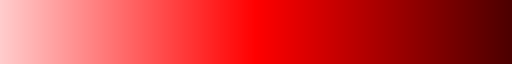

In [17]:
# colors = [(1, 0.8, 0.8), (1, 0, 0)]  # Light red to dark red
colors = [(1, 0.8, 0.8), (1, 0, 0), (0.3, 0, 0)]  # Red to darker red
cmap_custom = LinearSegmentedColormap.from_list("custom_reds", colors)
cmap_custom

### 5). Geospatial changes in conflicts (2022 - 2023)

- Cumulatively, total conflict events dropped by at least $100$ between 2022 and 2023, while a spike in the number of recorded fatalities was observed.

- The ***Tillabéri*** region, followed by the ***Diffa*** region, appears to be the most impacted across the years. An uptrend is observed for ***Tillabéri***, which recorded the significantly highest average conflict index (CI) of $40.59$ in 2023 (the year of the coup).

- The average CI in ***Diffa*** dropped to $12.31$ in 2023 from $15.39$ in 2022.

- The average CI in Tahoua region dropped from $7.89$ in 2021 to $4.31$ in 2022. This number only increased slightly to $4.67$ in 2023.

- These high average CIs in the ***Tillabéri*** region are mainly seen in Abala, Tillabéri and Téra departments or sub-regions.

- In the *"Conflict Index by Admin 1"* line graph, we also see that Tillabéri consistently recorded the highest conflict index of at least $20$ throughout the year, with a spike above $80$ in January 2024. The only exception to this trend occurred between March and April 2023 (before the coup), when Diffa's conflict index spiked above $55$ (the highest across the regions). This may be due to violence from Boko Haram in Nigeria, as Diffa is a common destination for refugees fleeing the violence, as previously reported by the International Rescue Committee in 2014.

- Conflict occurrences and fatalities in the Diffa region are concentrated in the southeastern part, covering the Diffa, Bosso and N'Guigmi sub-regions.

- From January 2019 to May 2024, ***Niamey*** capital district mostly maintained a conflict index of $0$, with occasional spikes between $1$ and $3$. Notably, there was one spike above 2 occurring around the coup date.

- The Agadez region experienced a high number of conflict events in 2022 and 2023, but with very few fatalities, leading to relatively low average CIs compared to the Maradi region.

- The Dosso and Zinder regions consistently experienced fewer conflict occurrences and fatalities across the years (2019-2023).



***In summary, the impact of the Niamey coup on July 26, 2023, in terms of the intensity of conflicts and consequent fatalities, measured by the average annual conflict index, was mostly observed in the Tillabéri region, which surrounds Niamey.***

#### a). Average conflict index by Admin 1 (Regions) in each year (2019 - 2023), to determine the intensity of conflict occurence and consequent fatalities.

In [18]:
### Ensure that the range of values in the legend is the same.

output_notebook()

## Include a year column derived from 'event_date'
niger_acled_adm1['year'] = niger_acled_adm1['event_date'].dt.year

## Calculate the mean conflict Index for each ADM1_FR by year, only accounting for non-NA entries
agg_data = niger_acled_adm1.groupby(['ADM1_FR', 'year']).agg({
    'conflictIndex': lambda x: round(x[x.notnull()].mean(), 2),
    'geometry': 'first'  # The first geometry as the representative for each ADM1_FR
}).reset_index()


## Convert the custom color map to a list of hex color codes
n_cols = 256
color_palette_new = [rgb2hex(cmap_custom(i / n_cols)) for i in range(n_cols)]


## Calculate the minimum and maximum values across the years to make the scale the same
global_min_conflict_index = agg_data['conflictIndex'].min()
global_max_conflict_index = agg_data['conflictIndex'].max()


def make_map_plot(year):
    p = figure(title=f"Average Conflict Index for {year} by Admin 1 (Régions)", 
               tools="pan, wheel_zoom, reset", 
               x_axis_location=None, y_axis_location=None, 
               width=900, height=600,  # Increase plot dimensions
               tooltips=[("ADM1 (Region)", "@ADM1_FR"), ("Average Conflict Index", "@conflictIndex")])
    p.grid.grid_line_color = None
    p.title.text_font_size = '18pt'
    
    ## Filter and simplify data for the year
    year_data = agg_data[agg_data['year'] == year].copy()
    year_data = year_data.set_geometry('geometry')  # Ensure geometry is recognized as GeoSeries
    year_data['geometry'] = year_data['geometry'].simplify(tolerance=0.01)
    
    ## Convert datetime columns to string to avoid issues with serialization
    geo_source = GeoJSONDataSource(geojson=year_data.to_json())
    
    # ## Create color mapper - Each map would have its own scale
    # color_mapper = LinearColorMapper(palette=color_palette_new, low=year_data['conflictIndex'].min(), high=year_data['conflictIndex'].max())

    ## Create color mapper with global min and max values - All maps would have the same scale
    color_mapper = LinearColorMapper(palette=color_palette_new, low=global_min_conflict_index, high=global_max_conflict_index)
    
    ## Add patches
    p.patches('xs', 'ys', source=geo_source, fill_color={'field': 'conflictIndex', 'transform': color_mapper},
              fill_alpha=1.0, line_color="black", line_width=0.4)
    
    ## Add color bar
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0,0))
    color_bar.major_label_text_font_size = '12pt' 
    p.add_layout(color_bar, 'right')
    
    return p

output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

## Create tabs for each year from 2019 to 2023
for year in range(2019, 2024):
    map_plot = make_map_plot(year)
    tabs.append(
        TabPanel(
            child=column(map_plot),
            title=str(year)
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)


Loading BokehJS ...

Loading BokehJS ...

#### b). Average conflict index by Admin 2 (Departments) in each year (2019 - 2023), to determine the specific areas (departments) in the region responsible for the observed intensity of conflict occurence and consequent fatalities.

In [20]:
output_notebook()

## Include a year column derived from 'event_date'
niger_acled_adm2['year'] = niger_acled_adm2['event_date'].dt.year

## Calculate the mean conflictIndex for each ADM2_FR by year, only accounting for non-NA entries
agg_data = niger_acled_adm2.groupby(['ADM2_FR', 'ADM1_FR', 'year']).agg({
    'conflictIndex': lambda x: round(x[x.notnull()].mean(), 2),
    'geometry': 'first'  # The first geometry as the representative for each ADM2_FR
}).reset_index()


## Convert the custom color map to a list of hex color codes
n_cols = 256
color_palette_new = [rgb2hex(cmap_custom(i / n_cols)) for i in range(n_cols)]


## Calculate the minimum and maximum values across the years to make the scale the same
global_min_conflict_index = agg_data['conflictIndex'].min()
global_max_conflict_index = agg_data['conflictIndex'].max()



def make_map_plot(year):
    p = figure(title=f"Average Conflict Index for {year} by Admin 2 (Départements)", 
               tools="pan, wheel_zoom, reset", 
               x_axis_location=None, y_axis_location=None, 
               width=900, height=600,  # Increase plot dimensions
               tooltips=[("ADM2 (Department)", "@ADM2_FR"), ("Average Conflict Index", "@conflictIndex"), ("ADM1 (Region)", "@ADM1_FR")])
    p.grid.grid_line_color = None
    p.title.text_font_size = '18pt'
    
    ## Filter and simplify data for the year
    year_data = agg_data[agg_data['year'] == year].copy()
    year_data = year_data.set_geometry('geometry')  # Ensure geometry is recognized as GeoSeries
    year_data['geometry'] = year_data['geometry'].simplify(tolerance=0.01)
    
    ## Convert datetime columns to string to avoid issues with serialization
    geo_source = GeoJSONDataSource(geojson=year_data.to_json())
    

    ## Create color mapper with global min and max values - All maps would have the same scale
    color_mapper = LinearColorMapper(palette=color_palette_new, low=global_min_conflict_index, high=global_max_conflict_index)
    
    ## Add patches
    p.patches('xs', 'ys', source=geo_source, fill_color={'field': 'conflictIndex', 'transform': color_mapper},
              fill_alpha=1.0, line_color="black", line_width=0.4)
    
    ## Add color bar
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0,0))
    color_bar.major_label_text_font_size = '12pt' 
    p.add_layout(color_bar, 'right')
    
    return p

output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

## Create tabs for each year from 2019 to 2023
for year in range(2019, 2024):
    map_plot = make_map_plot(year)
    tabs.append(
        TabPanel(
            child=column(map_plot),
            title=str(year)
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)





Loading BokehJS ...

Loading BokehJS ...

In [44]:
# fig, ax = plt.subplots(1, 2, sharex=True, figsize=(18, 10))

# acled_22.plot(
#     column="count", cmap=cmap_custom, ax=ax[0], markersize="sizeCategory", marker="o"
# )
# niger_adm1.boundary.plot(ax=ax[0], color="grey", alpha=0.6, linewidth=1)
# # niger_adm1.boundary.plot(ax=ax[0], color=niger_adm1['ADM1_FR'].map(color_palette3), linewidth=1)
# ax[0].set_title("Fatalities and Conflicts in 2022")

# acled_23.plot(column="count", cmap=cmap_custom, ax=ax[1], markersize="sizeCategory")
# niger_adm1.boundary.plot(ax=ax[1], color="grey", alpha=0.6, linewidth=1)
# ax[1].set_title("Fatalities and Conflicts in 2023")

# # ## Calculate the positions for adding ADM1_FR as labels
# # niger_adm1['centroid'] = niger_adm1.geometry.centroid
# # for idx, row in niger_adm1.iterrows():
# #     # Set positions for labels
# #     position = row['geometry'].representative_point()  
# #     # Add text annotations
# #     ax[0].annotate(text=row['ADM1_FR'], xy=(position.x, position.y), xytext=(3, 3), textcoords="offset points")
# #     ax[1].annotate(text=row['ADM1_FR'], xy=(position.x, position.y), xytext=(3, 3), textcoords="offset points")



# # Create a colorbar and link it to the second axes
# sm = plt.cm.ScalarMappable(cmap=cmap_custom)
# sm.set_array(acled_23["count"])
# cbar = plt.colorbar(sm, ax=ax, location='right', aspect=40, pad=0.1)
# cbar.set_label("Number of conflict events")

# for i in [0, 1]:
#     ax[i].spines["top"].set_visible(False)
#     ax[i].spines["bottom"].set_visible(False)
#     ax[i].spines["left"].set_visible(False)
#     ax[i].spines["right"].set_visible(False)

#     ax[i].set_xticks([])
#     ax[i].set_yticks([])

# sizes = acled_23.sort_values(by="sizeCategory")["sizeCategory"].unique()
# handles = []
# for size in sizes:
#     (handle,) = ax[0].plot(
#         [],
#         [],
#         marker="o",
#         markersize=size / 3,
#         linestyle="",
#         label=sizeCategoryLabels[size],
#         markerfacecolor="white",
#         markeredgecolor="black",
#     )
#     handles.append(handle)
# ax[0].legend(
#     handles=handles,
#     title="Number of fatalities",
#     loc="upper left",
#     frameon=False,
#     bbox_to_anchor=(0.9, 0.1)
# )

# plt.show()


#### c). Top 5 worst affected admin 1 regions in 2022

In [21]:
niger_acled_adm1[niger_acled_adm1["event_date"].between("2022-01-01", "2022-12-31")].groupby(
    [pd.Grouper(key="event_date", freq="Y"), "ADM1_FR"]
).sum(["fatalities", "event_id_cnty"]).reset_index().sort_values(
    by="event_id_cnty", ascending=False
)[["event_date", "ADM1_FR", "fatalities", "event_id_cnty"]].head(5)

C:\Users\wb620404\AppData\Local\Temp\ipykernel_19740\2563770677.py:2: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



,event_date,ADM1_FR,fatalities,event_id_cnty
6,2022-12-31,Tillabéri,592,357
1,2022-12-31,Diffa,251,159
0,2022-12-31,Agadez,33,156
3,2022-12-31,Maradi,41,139
5,2022-12-31,Tahoua,49,96


#### d). Top 5 worst affected admin 1 regions in 2023

In [22]:
niger_acled_adm1[niger_acled_adm1["event_date"].between("2023-01-01", "2023-12-31")].groupby(
    [pd.Grouper(key="event_date", freq="Y"), "ADM1_FR"]
).sum(["fatalities", "event_id_cnty"]).reset_index().sort_values(
    by="event_id_cnty", ascending=False
)[["event_date", "ADM1_FR", "fatalities", "event_id_cnty"]].head(5)

C:\Users\wb620404\AppData\Local\Temp\ipykernel_19740\1345114302.py:2: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



,event_date,ADM1_FR,fatalities,event_id_cnty
6,2023-12-31,Tillabéri,738,383
1,2023-12-31,Diffa,224,127
5,2023-12-31,Tahoua,95,76
3,2023-12-31,Maradi,31,70
0,2023-12-31,Agadez,30,54


#### e). Total Conflicts and Fatalities in Niger (1st January, 2019 - 15th May, 2024)

In [23]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

## Rename "event_id_cnty" as "conflicts"
niger_acled_adm0.rename(columns={'event_id_cnty': 'conflicts'}, inplace=True)


for type in ["conflicts", "fatalities"]:
    tabs.append(
        TabPanel(
            child=get_line_plot(
                niger_acled_adm0,
                f"{type.capitalize()} in the country",
                "Source: ACLED",
                subtitle="",
                category="country",
                measure=type,
            ),
            title=type.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

#### f). Conflict Index across the 7 regions and Niamey (1st Januray, 2019 - 15th May, 2024)

In [24]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

tabs.append(
    TabPanel(
        child=get_line_plot(
            niger_acled_adm1,
            "Conflict Index by admin 1",
            "Source: ACLED",
            subtitle="",
            category="ADM1_FR",
        ),
        
    )
)

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

#### g). Conflict Index across the sub-regions or departments (1st Januray, 2019 - 15th May, 2024)

In [25]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)


tabs = []

for adm in list(niger_acled_adm2["ADM1_FR"].unique()):
    df = niger_acled_adm2[niger_acled_adm2["ADM1_FR"] == adm]

    tabs.append(
        TabPanel(
            child=get_line_plot(
                df,
                "Conflict Index by admin 2",
                "Source: ACLED",
                subtitle="",
            ),
            title=adm.capitalize(),
        )
    )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...